# Example: Investigating Significant Wave Height - Southern California

`intake-erddap` makes it extremely easy to quickly find station data from an ERDDAP instance, and integrate that information however is desired.

In [2]:
import intake_erddap
import intake
import numpy as np

import cartopy.crs as ccrs

import pandas as pd

from matplotlib import pyplot as plt
from shapely import geometry

from datetime import datetime

In [3]:
def figure(*args, figsize=(18, 8), facecolor='white', **kwargs):
    return plt.subplots(*args, figsize=figsize, facecolor=facecolor, **kwargs)

Here's an example of finding _all_ stations that have significant wave height from the main IOOS ERDDAP server.

In [4]:
server = 'https://erddap.sensors.ioos.us/erddap'
cat = intake.open_erddap_cat(
    server=server,
    standard_names=["sea_surface_wind_wave_significant_height"]
)

In [5]:
df = pd.DataFrame([i.metadata for i in cat.values()])
df[['datasetID', 'minTime', 'maxTime', 'title']]

,datasetID,minTime,maxTime,title
0,wmo_46023,2010-01-01T00:50:00Z,2010-09-08T13:50:00Z,"17 NM WNW of Point Arguello, CA (46023)"
1,wmo_46059,2010-12-12T01:50:00Z,2022-12-16T11:10:00Z,"357 NM West of San Francisco, CA (46059)"
2,wmo_41001,2015-12-11T02:20:00Z,2022-12-16T11:50:00Z,41001 - EAST HATTERAS - 150 NM East of Cape Ha...
3,wmo_41002,2015-05-05T12:50:00Z,2022-12-16T11:40:00Z,41002 - SOUTH HATTERAS - 225 NM South of Cape ...
4,wmo_41004,2015-05-05T12:50:00Z,2022-12-16T11:40:00Z,41004 - EDISTO - 41 NM Southeast of Charleston...
...,...,...,...,...
176,wmo_46026,2010-02-11T19:50:00Z,2022-12-16T11:10:00Z,"San Francisco - 18 NM West of San Francisco, C..."
177,wmo_46011,2010-02-16T22:50:00Z,2022-12-16T11:10:00Z,"Santa Maria - 21 NM NW of Point Arguello, CA (..."
178,wmo_46006,2011-10-15T21:50:00Z,2022-12-16T11:00:00Z,"Southeast Papa - 600 NM West of Eureka, CA (46..."
179,wmo_46027,2010-01-01T00:50:00Z,2022-12-16T11:10:00Z,"St Georges - 8 NM NW of Crescent City, CA (46027)"


We can plot the locations of these stations on the globe

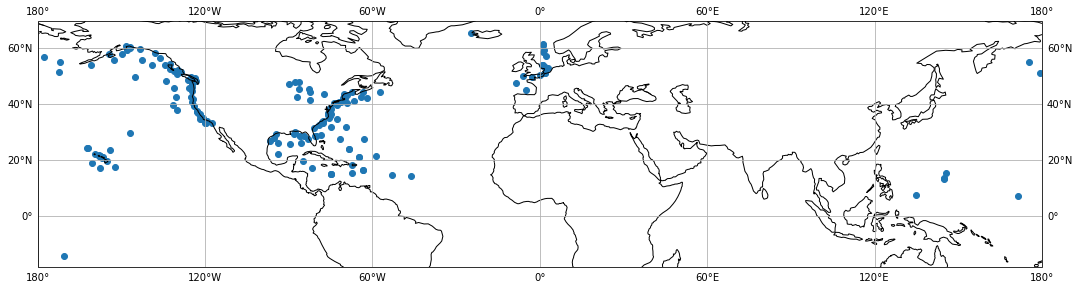

In [6]:
fig, ax = figure(subplot_kw=dict(projection=ccrs.PlateCarree()))
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.scatter(df['minLongitude'], df['minLatitude'])

Since our region of interest is off the coast of Southern California, we'll specify a bounding box and highlight the stations that intersect our region.

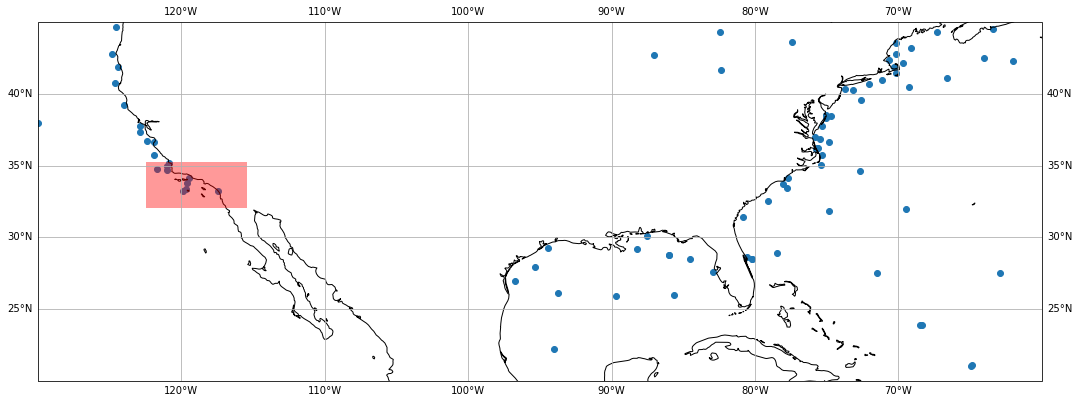

In [7]:
# Southern California Region
bbox = (-122.42, 32.04, -115.40, 35.28)
box = geometry.box(*bbox)

fig, ax = figure(subplot_kw=dict(projection=ccrs.PlateCarree()))
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.scatter(df['minLongitude'], df['minLatitude'])
ax.add_geometries([box], facecolor='red', alpha=0.4, crs=ccrs.PlateCarree())
ax.set_extent([-130., -60., 20., 45.], crs=ccrs.PlateCarree())

We can pass this bounding box directly to the ERDDAP Catalog constructor, as well as limit our query only to stations that contain data after 2014:

In [8]:
cat = intake.open_erddap_cat(
    server=server,
    bbox=bbox,
    start_time=datetime(2014, 1, 1),
    standard_names=["sea_surface_wind_wave_significant_height"]
)

len(cat)

8

In [9]:
df = pd.DataFrame([i.metadata for i in cat.values()])
df[['datasetID', 'minTime', 'maxTime', 'title']]

,datasetID,minTime,maxTime,title
0,edu_ucsd_cdip_46219,2015-05-05T14:05:00Z,2022-12-16T10:56:00Z,"46219 - San Nicolas Island, CA (067)"
1,edu_ucsd_cdip_46242,2015-05-05T12:28:00Z,2019-07-27T15:28:00Z,"46242 - Camp Pendleton Nearshore, CA (043)"
2,edu_ucsd_cdip_46251,2015-07-17T16:51:00Z,2022-12-16T10:56:00Z,"46251 - Santa Cruz Basin, CA"
3,edu_ucsd_cdip_46255,2015-12-11T02:07:00Z,2017-04-02T04:16:00Z,"46255 - Begg Rock, CA (138)"
4,mil_army_usace_46259,2016-03-29T18:00:00Z,2022-12-16T11:56:00Z,"46259 - Santa Lucia Escarpment, CA (222)"
5,edu_ucsd_cdip_46217,2015-05-05T14:07:00Z,2019-05-13T02:04:00Z,"Anacapa Passage, CA - 111 (46217)"
6,edu_ucsd_cdip_46215,2009-12-02T16:13:00Z,2022-12-16T10:56:00Z,"Diablo Canyon, CA - 076 (46215)"
7,wmo_46011,2010-02-16T22:50:00Z,2022-12-16T11:10:00Z,"Santa Maria - 21 NM NW of Point Arguello, CA (..."


Text(0.5, 1.0, 'Station Locations')

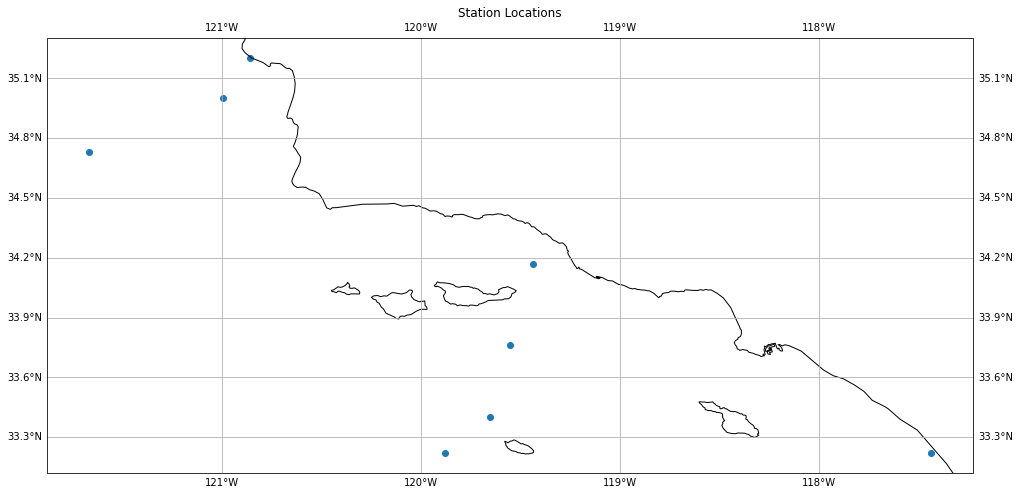

In [10]:
# Southern California Region
bbox = (-122.42, 32.04, -115.40, 35.28)
box = geometry.box(*bbox)

fig, ax = figure(subplot_kw=dict(projection=ccrs.PlateCarree()))
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.scatter(df['minLongitude'], df['minLatitude'])
ax.set_title("Station Locations")

We can now interrogate each of those stations and get a timeseries for the significant wave height data.

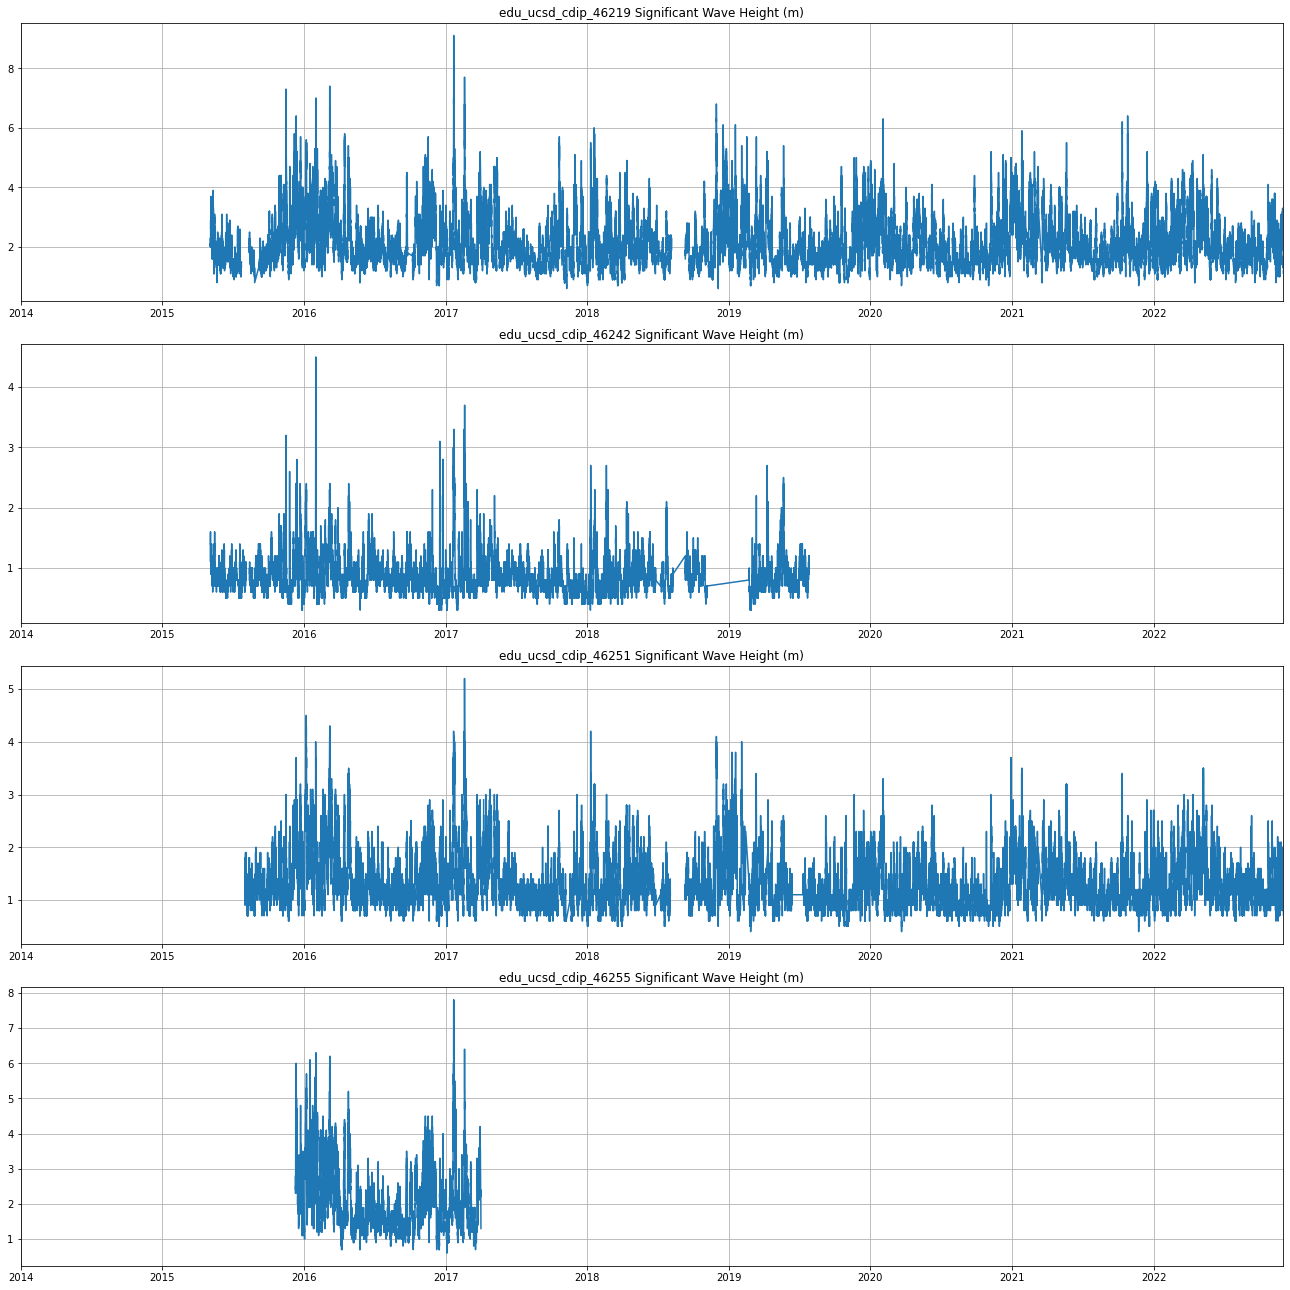

In [14]:

# Just get 4
stations = list(cat)[:4]

fig, axs = figure(nrows=len(stations), figsize=(18,18))

for i, dataset_id in enumerate(stations):
    ax = axs[i]
    source = cat[dataset_id]
    df = source.read()
    t = df['time (UTC)'].astype('M8[s]')
    sig_wave_height = df['sea_surface_wave_significant_height (m)']
    ax.plot(t, sig_wave_height)
    ax.set_title(f'{dataset_id} Significant Wave Height (m)')
    ax.set_xlim(np.datetime64('2014-01-01'), np.datetime64('2022-12-01'))
    ax.grid()
fig.tight_layout(pad=1)